# [0] 모듈 로드

In [2]:
# Data
import pandas as pd
import numpy as np
import os
import time
from collections import Counter

# EDA 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import rc
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False
import matplotlib.patches as mpatches


# DL 
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

# ML preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE
from scipy.stats.mstats import winsorize

# ML Model
from xgboost import XGBClassifier
import xgboost
from catboost import CatBoostClassifier
import catboost
import sklearn
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# ML metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

- 각 데이터는 차원축소되어 있는 상태 (시간과 거래액 제외)
- 시간은 데이터셋 내 첫번째 거래가 이루어진 시점부터 각 거래가 이루어진 시점 사이의 시간을 초 단위로 기록한것임

<br/>

- 총 284,807건의 거래데이터가 있으며 각 Column정보는 아래와 같음

<br/>

- V1 ~ V28 : 특성 비공개
- Time : 시간
- Amount : 거래금액
- Class : 사기 여부 (1 : 사기, 0 : 정상)
- 총 31개 Column이 있으며 이 중 시간과 거래금액을 뺀 V1 ~ B=V28 데이터로부터 사기 여부 (Class)를 예측하는것을 목표로 함.

# [1] 데이터 로드

In [3]:
df = pd.read_csv('./data/creditcard.csv')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Volume of data
print(df.shape)

(284807, 31)


# [2] 데이터 확인 및 전처리

- 정상 거래의 비중이 매우 높음 (데이터 불균형 문제)

## [2-1] Target 분포 확인

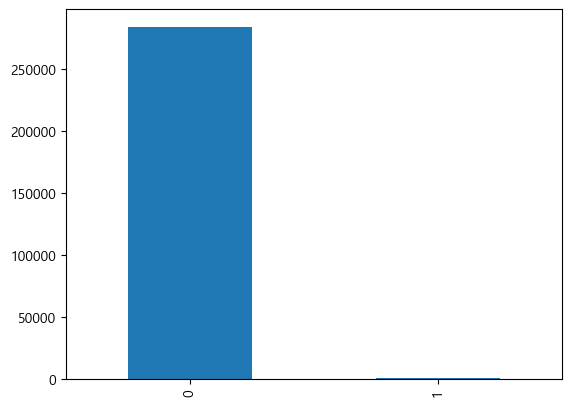

In [6]:
df['Class'].value_counts().plot(kind = 'bar')
plt.show()

## [2-2] NA 확인
- NA값은 없음

In [7]:
df.info() # NA값 현재 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
# 사기 거래와 일반 거래 분할
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [9]:
frauds

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [10]:
# 시간은 우선 제외
data = df.drop(['Time'], axis = 1)

## [2-3] Scaling

- Amount 칼럼만 스케일링 작업을 진행해주면 된다.

In [11]:
scaler = StandardScaler()

data['Amount'] = scaler.fit_transform(data['Amount'].values.reshape(-1,1))

In [12]:
# Scaling 확인
data.Amount

0         0.244964
1        -0.342475
2         1.160686
3         0.140534
4        -0.073403
            ...   
284802   -0.350151
284803   -0.254117
284804   -0.081839
284805   -0.313249
284806    0.514355
Name: Amount, Length: 284807, dtype: float64

In [13]:
y = data['Class']
X = data.drop(['Class'], axis = 1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 22)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227845, 29), (56962, 29), (227845,), (56962,))

In [15]:
# 딥러닝 학습을 위해 numpy array 형태로 변환
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

# [3] Auto Encoder를 활용한 Deeplearning 학습

- AutoEncoder 모델 구조 (14 -> 7 -> 7 -> 14)

<br/>

- 정상 데이터만으로 오토인코더 학습 후
- 이상 데이터가 포함된 데이터 예측

<br/>

- 정상 데이터로 학습되었기 때문에 비정상 데이터를 이 모델로 예측할 경우,  ******비교적 높은 오차를 보일것******

=> 임계치 10 기준 분류하였을 때 99%의 이상거래를 탐지해냄 (단, 이상거래의 수가 현저히 적기 때문에, 이를 고려할 필요가 있음)
=> F1 점수는 

------------------------
- threshold 조절, 동적 threshold 이동평균, kama 등으로 조절로 성능 향상 가능
- upsampling 필요 

## [3-1] Train Test split

In [16]:
normal = data[data.Class == 0]

In [17]:
y = normal['Class']
X = normal.drop(['Class'], axis = 1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 22)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227452, 29), (56863, 29), (227452,), (56863,))

In [19]:
# 딥러닝 학습을 위해 numpy array 형태로 변환
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

## [3-1] 오토인코더 모델 생성

In [166]:
input_dim = X_train_np.shape[1]
encoding_dim = 16

model = Sequential()

# Encoding
model.add(Dense(units = encoding_dim, input_dim = input_dim, activation = 'relu'))
model.add(Dense(units = 12, activation = 'relu'))
model.add(Dense(units = 8, activation = 'relu'))
model.add(Dense(units = 4, activation = 'relu'))
model.add(Dense(units = 2, activation = 'relu'))

# Decoding
model.add(Dense(units = 4, activation = 'relu'))
model.add(Dense(units = 8, activation = 'relu'))
model.add(Dense(units = 12, activation = 'relu'))
model.add(Dense(units = 16, activation = 'relu'))

model.add(Dense(units = input_dim, activation = 'relu'))

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['acc'])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 16)                480       
                                                                 
 dense_70 (Dense)            (None, 12)                204       
                                                                 
 dense_71 (Dense)            (None, 8)                 104       
                                                                 
 dense_72 (Dense)            (None, 4)                 36        
                                                                 
 dense_73 (Dense)            (None, 2)                 10        
                                                                 
 dense_74 (Dense)            (None, 4)                 12        
                                                                 
 dense_75 (Dense)            (None, 8)               

## [3-3] 오토인코더 모델 학습

In [167]:
history = model.fit(X_train_np, X_train_np, epochs = 10, shuffle = True, validation_split = 0.20)

Epoch 1/10
5687/5687 [==============================] - 10s 2ms/step - loss: 0.9778 - acc: 0.2121 - val_loss: 0.9888 - val_acc: 0.2397
Epoch 2/10
5687/5687 [==============================] - 9s 2ms/step - loss: 0.9519 - acc: 0.2798 - val_loss: 0.9723 - val_acc: 0.2748
Epoch 3/10
5687/5687 [==============================] - 9s 2ms/step - loss: 0.9438 - acc: 0.2762 - val_loss: 0.9696 - val_acc: 0.2996
Epoch 4/10
5687/5687 [==============================] - 9s 2ms/step - loss: 0.9425 - acc: 0.2890 - val_loss: 0.9693 - val_acc: 0.2976
Epoch 5/10
5687/5687 [==============================] - 9s 2ms/step - loss: 0.9419 - acc: 0.2938 - val_loss: 0.9703 - val_acc: 0.2983
Epoch 6/10
5687/5687 [==============================] - 9s 2ms/step - loss: 0.9426 - acc: 0.3074 - val_loss: 0.9715 - val_acc: 0.2814
Epoch 7/10
5687/5687 [==============================] - 9s 2ms/step - loss: 0.9466 - acc: 0.2940 - val_loss: 0.9732 - val_acc: 0.2839
Epoch 8/10
5687/5687 [==============================] - 9s 2m

## [3-4] 예측

In [168]:
target_fot_test_AE = data.Class
data_for_test_AE = data.drop(['Class'], axis = 1)

In [169]:
predictions = model.predict(data_for_test_AE)
predictions

8901/8901 [==============================] - 6s 717us/step


array([[0.        , 0.        , 2.1023536 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.67104286, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.348962  , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.9382174 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.47100466, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

## [3-5] 성능 확인

In [170]:
mse = np.mean((data_for_test_AE - predictions) ** 2, axis = 1 )
err_df = pd.DataFrame({'mse' : mse, 'class' : target_fot_test_AE})

err_df

,mse,class
0,0.253425,0
1,0.252744,0
2,1.088130,0
3,0.523477,0
4,0.359061,0
...,...,...
284802,14.816345,0
284803,0.499797,0
284804,0.696329,0
284805,0.725772,0


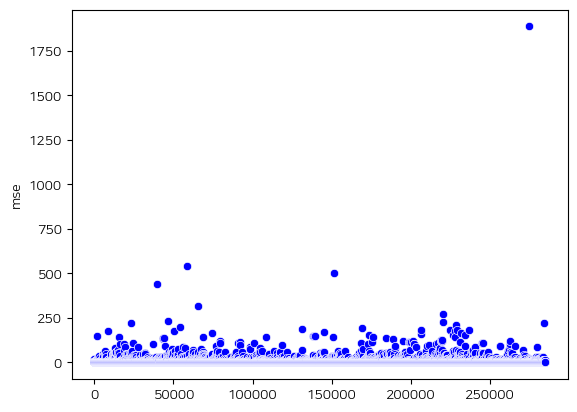

In [171]:
tmp = err_df[err_df['class'] == 0]
sns.scatterplot(x = tmp.index, y='mse', data=tmp, c = 'b')

plt.show()

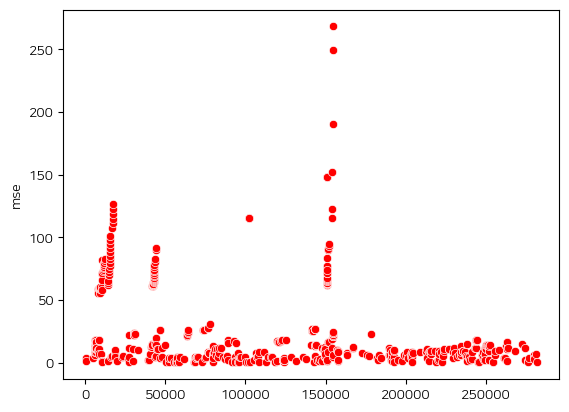

In [172]:
tmp = err_df[err_df['class'] == 1]
sns.scatterplot(x = tmp.index, y='mse', data=tmp, c = 'r')

plt.show()

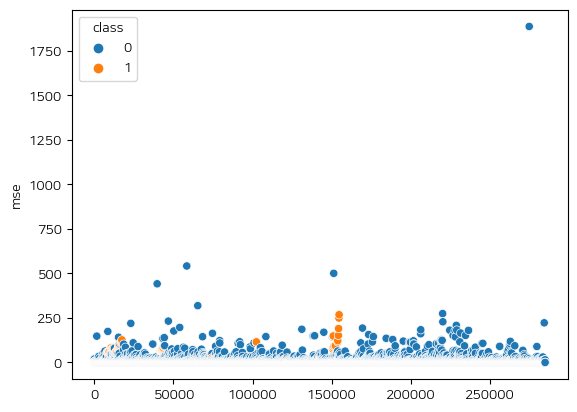

In [173]:
sns.scatterplot(x = err_df.index, y='mse', hue='class', data=err_df)

plt.show()

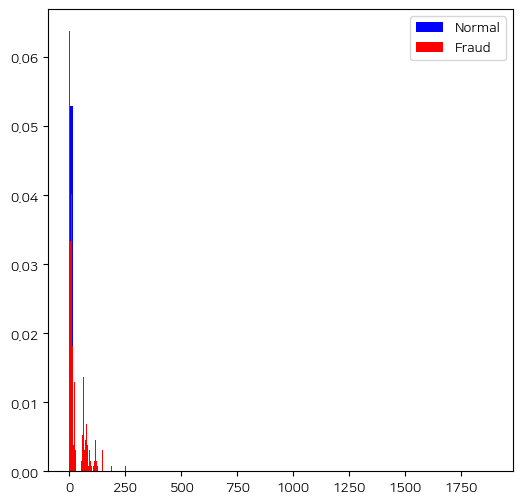

In [174]:
tmp_0 = err_df[err_df['class'] == 0]
tmp_1 = err_df[err_df['class'] == 1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(tmp_0.mse, bins = 100, density = True, label = 'Normal', color = 'blue')
ax.hist(tmp_1.mse, bins = 100, density = True, label = 'Fraud', color = 'red')

plt.legend()

plt.show()

In [175]:
threshhold = 50
y_pred = [1 if e > threshhold else 0 for e in err_df['mse'].values]

In [176]:
(target_fot_test_AE == y_pred).mean()

0.9979635331996756

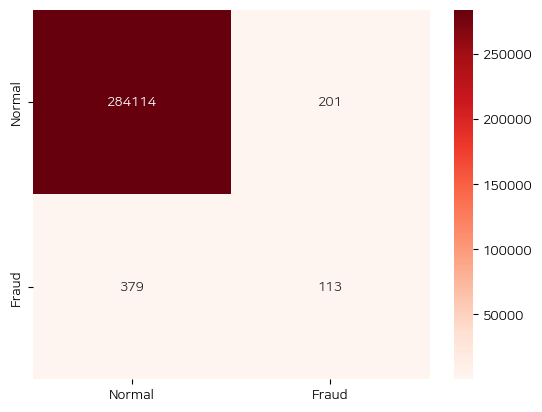

In [177]:
conf = confusion_matrix(target_fot_test_AE, y_pred)

sns.heatmap(conf, annot = True, fmt = 'd', cmap = 'Reds',
           xticklabels = ['Normal', 'Fraud'], yticklabels = ['Normal', 'Fraud'])

plt.show()

In [178]:
f1_score(target_fot_test_AE, y_pred)

0.2803970223325062

-----------------------------------------------------------
### - **Auto Encoder 한계 확인**

### - **오버샘플링 및 이상치 처리 후 머신러닝 모델로 접근해보자!**
-----------------------------------------------------------

# [4] 이상치 처리 (MinMax scaler, log변환)

- Log 변환을 위해 Minmaxscaling (log변환을 위해서는 0보다 커야함)
- Log 변환
- 분포를 비교해봤을 때 비교적 이상치가 처리되었음을 확인할 수 있음.

In [22]:
# 시각화 파라미터
palette = ['#36ada4', '#f77189'] 


custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    'grid.alpha':0.1,
    'axes.titlesize': 15,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
}

sns.set_theme(
    style='whitegrid',
    palette=sns.color_palette(palette),
    rc=custom_params
)

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

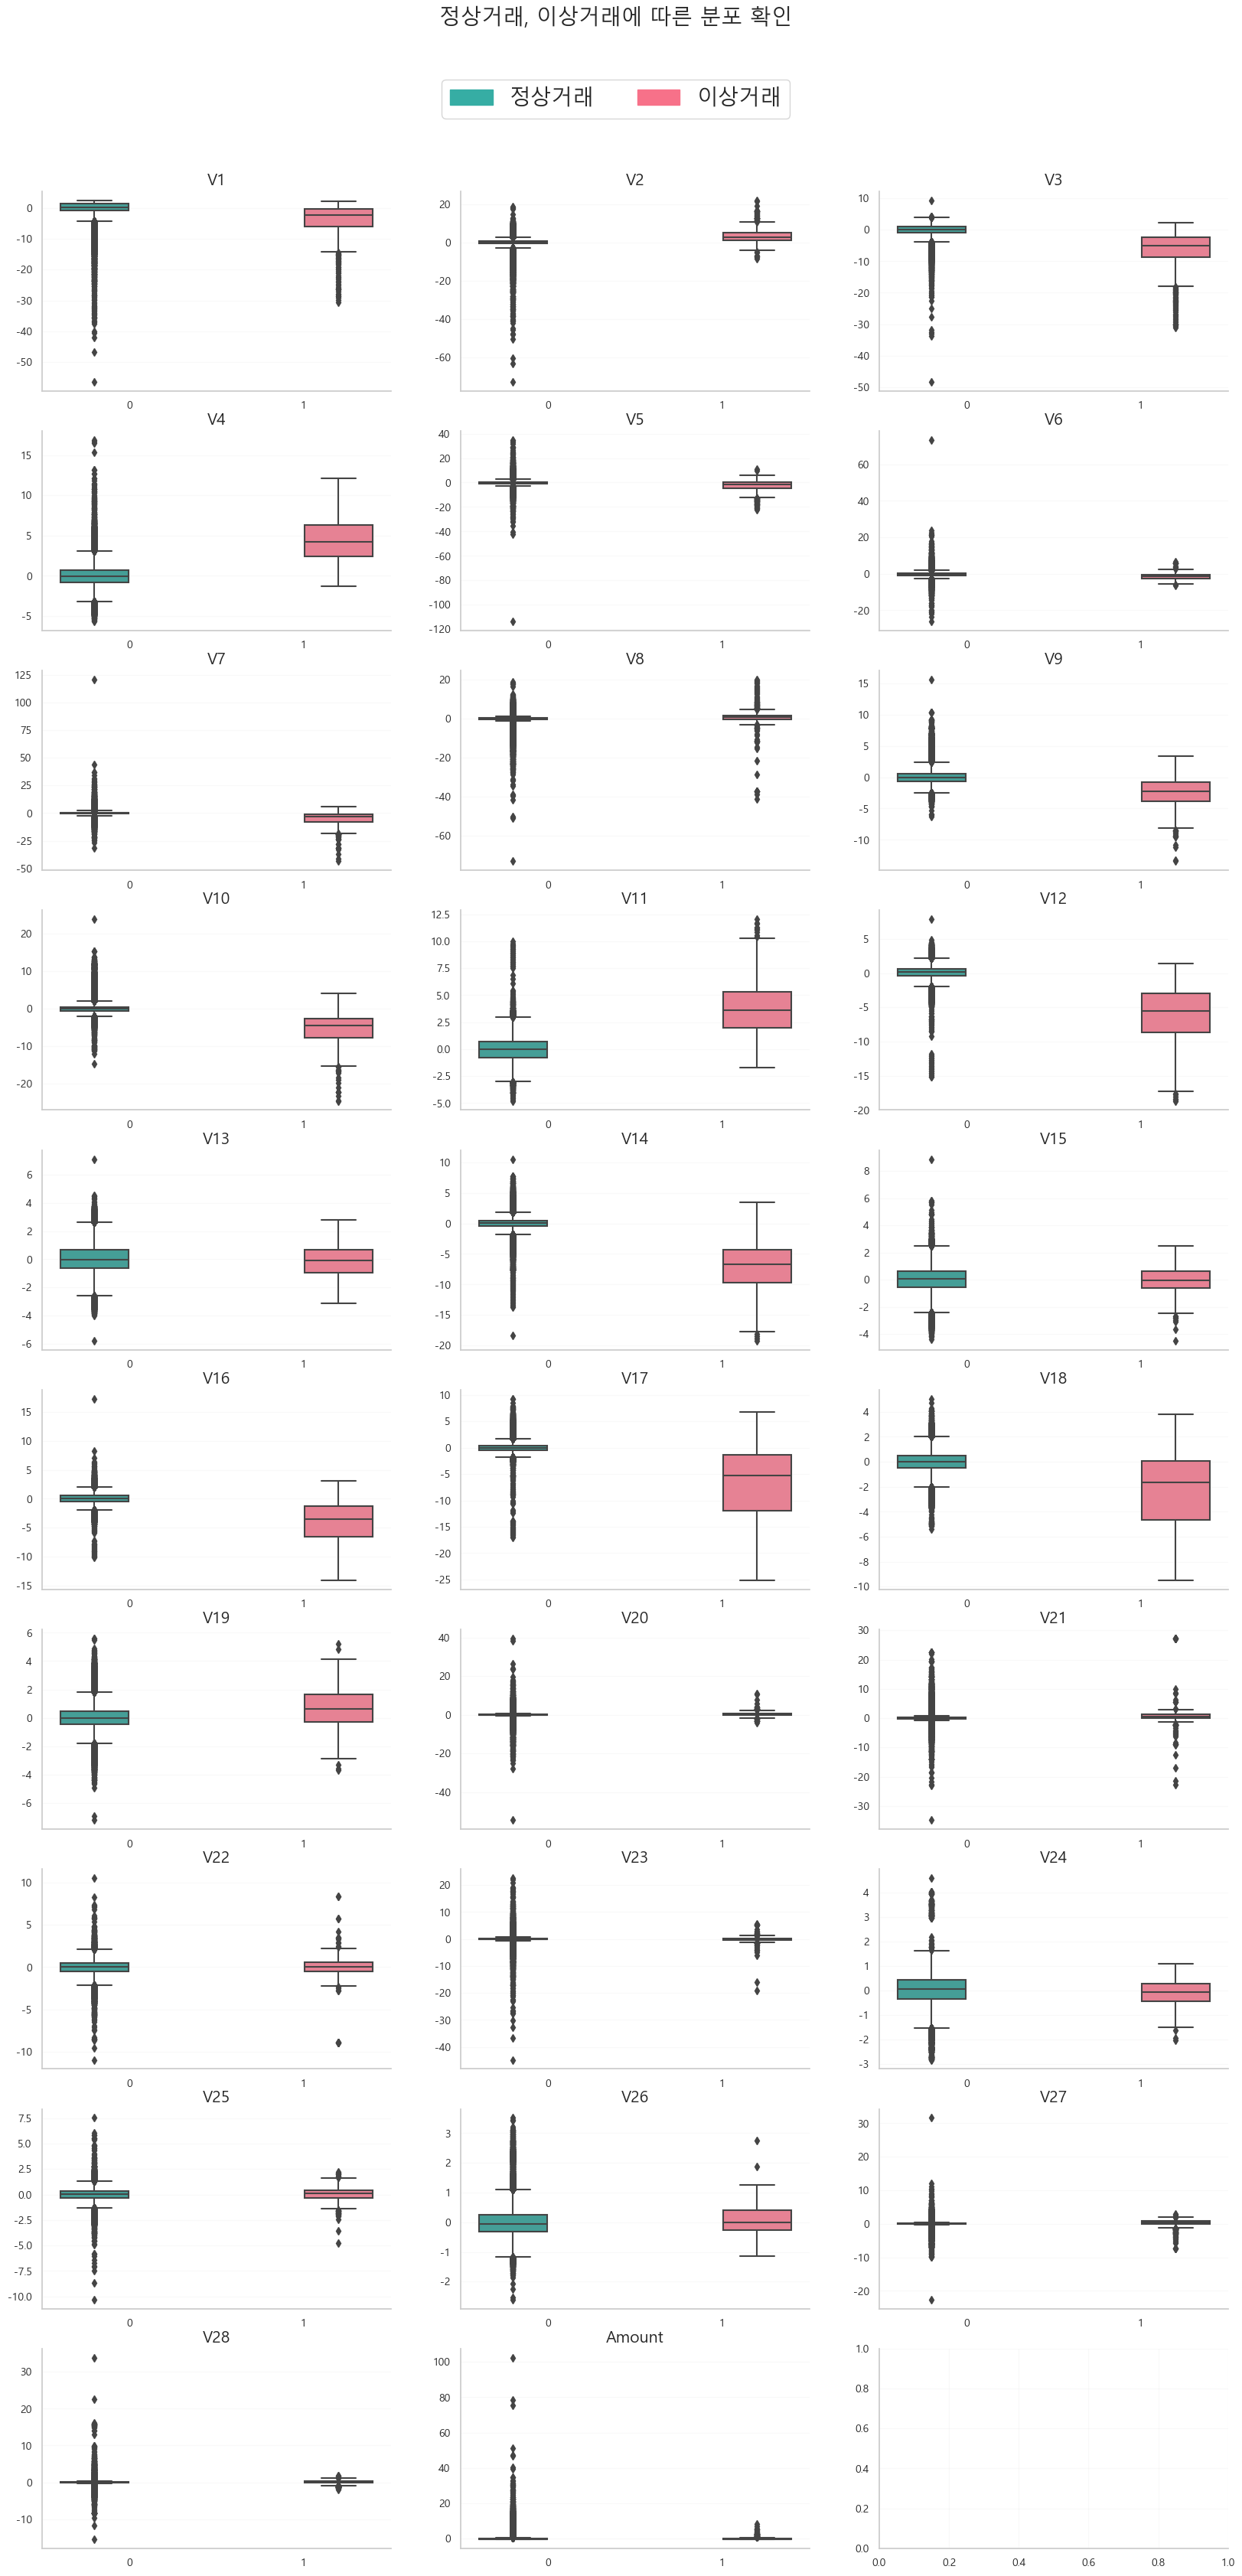

In [23]:
fig, ax = plt.subplots(10,3,figsize=(20, 40))

palette = ['#36ada4', '#f77189'] 

ax = ax.flatten()

total_col = data.columns
total_col = total_col.drop(['Class'])

for idx, col in enumerate(
    total_col):
    sns.boxplot(data=data, y= col, x="Class", hue='Class', ax=ax[idx])
    ax[idx].legend().remove()
    ax[idx].set(title = col)
    ax[idx].set(xlabel=None)
    ax[idx].set(ylabel=None)
    
labels = ['정상거래', '이상거래']
pop_a = mpatches.Patch(color=palette[0], label=labels[0])
pop_b = mpatches.Patch(color=palette[1], label=labels[1])

fig.legend(handles=[pop_a,pop_b], loc='upper center', bbox_to_anchor=(0.5, .92), fontsize=20, ncol=2)
fig.suptitle('정상거래, 이상거래에 따른 분포 확인', fontsize=20, y=.94)
plt.show()

### [+] Min Max Scaler

In [24]:
mms = MinMaxScaler()
scaled_X = mms.fit_transform(data.iloc[:,0:28])

In [25]:
data_sc = pd.DataFrame(scaled_X, columns= data.columns[0:28])
data_sc['Class'] = data['Class']

### [+] Log 변환

In [26]:
data_log = data_sc.copy()

for col in data_sc.columns[0:29]:
    data_log[col] = np.log(data_sc[col] + 1)

In [27]:
data_w = data.copy()

for col in data_w.columns[:29] :
    data_w[col] = winsorize(data_w[col], limits=[0.05, 0.05])

### [+] 이상치 처리 후 정상거래, 이상거래 분포 다시 확인

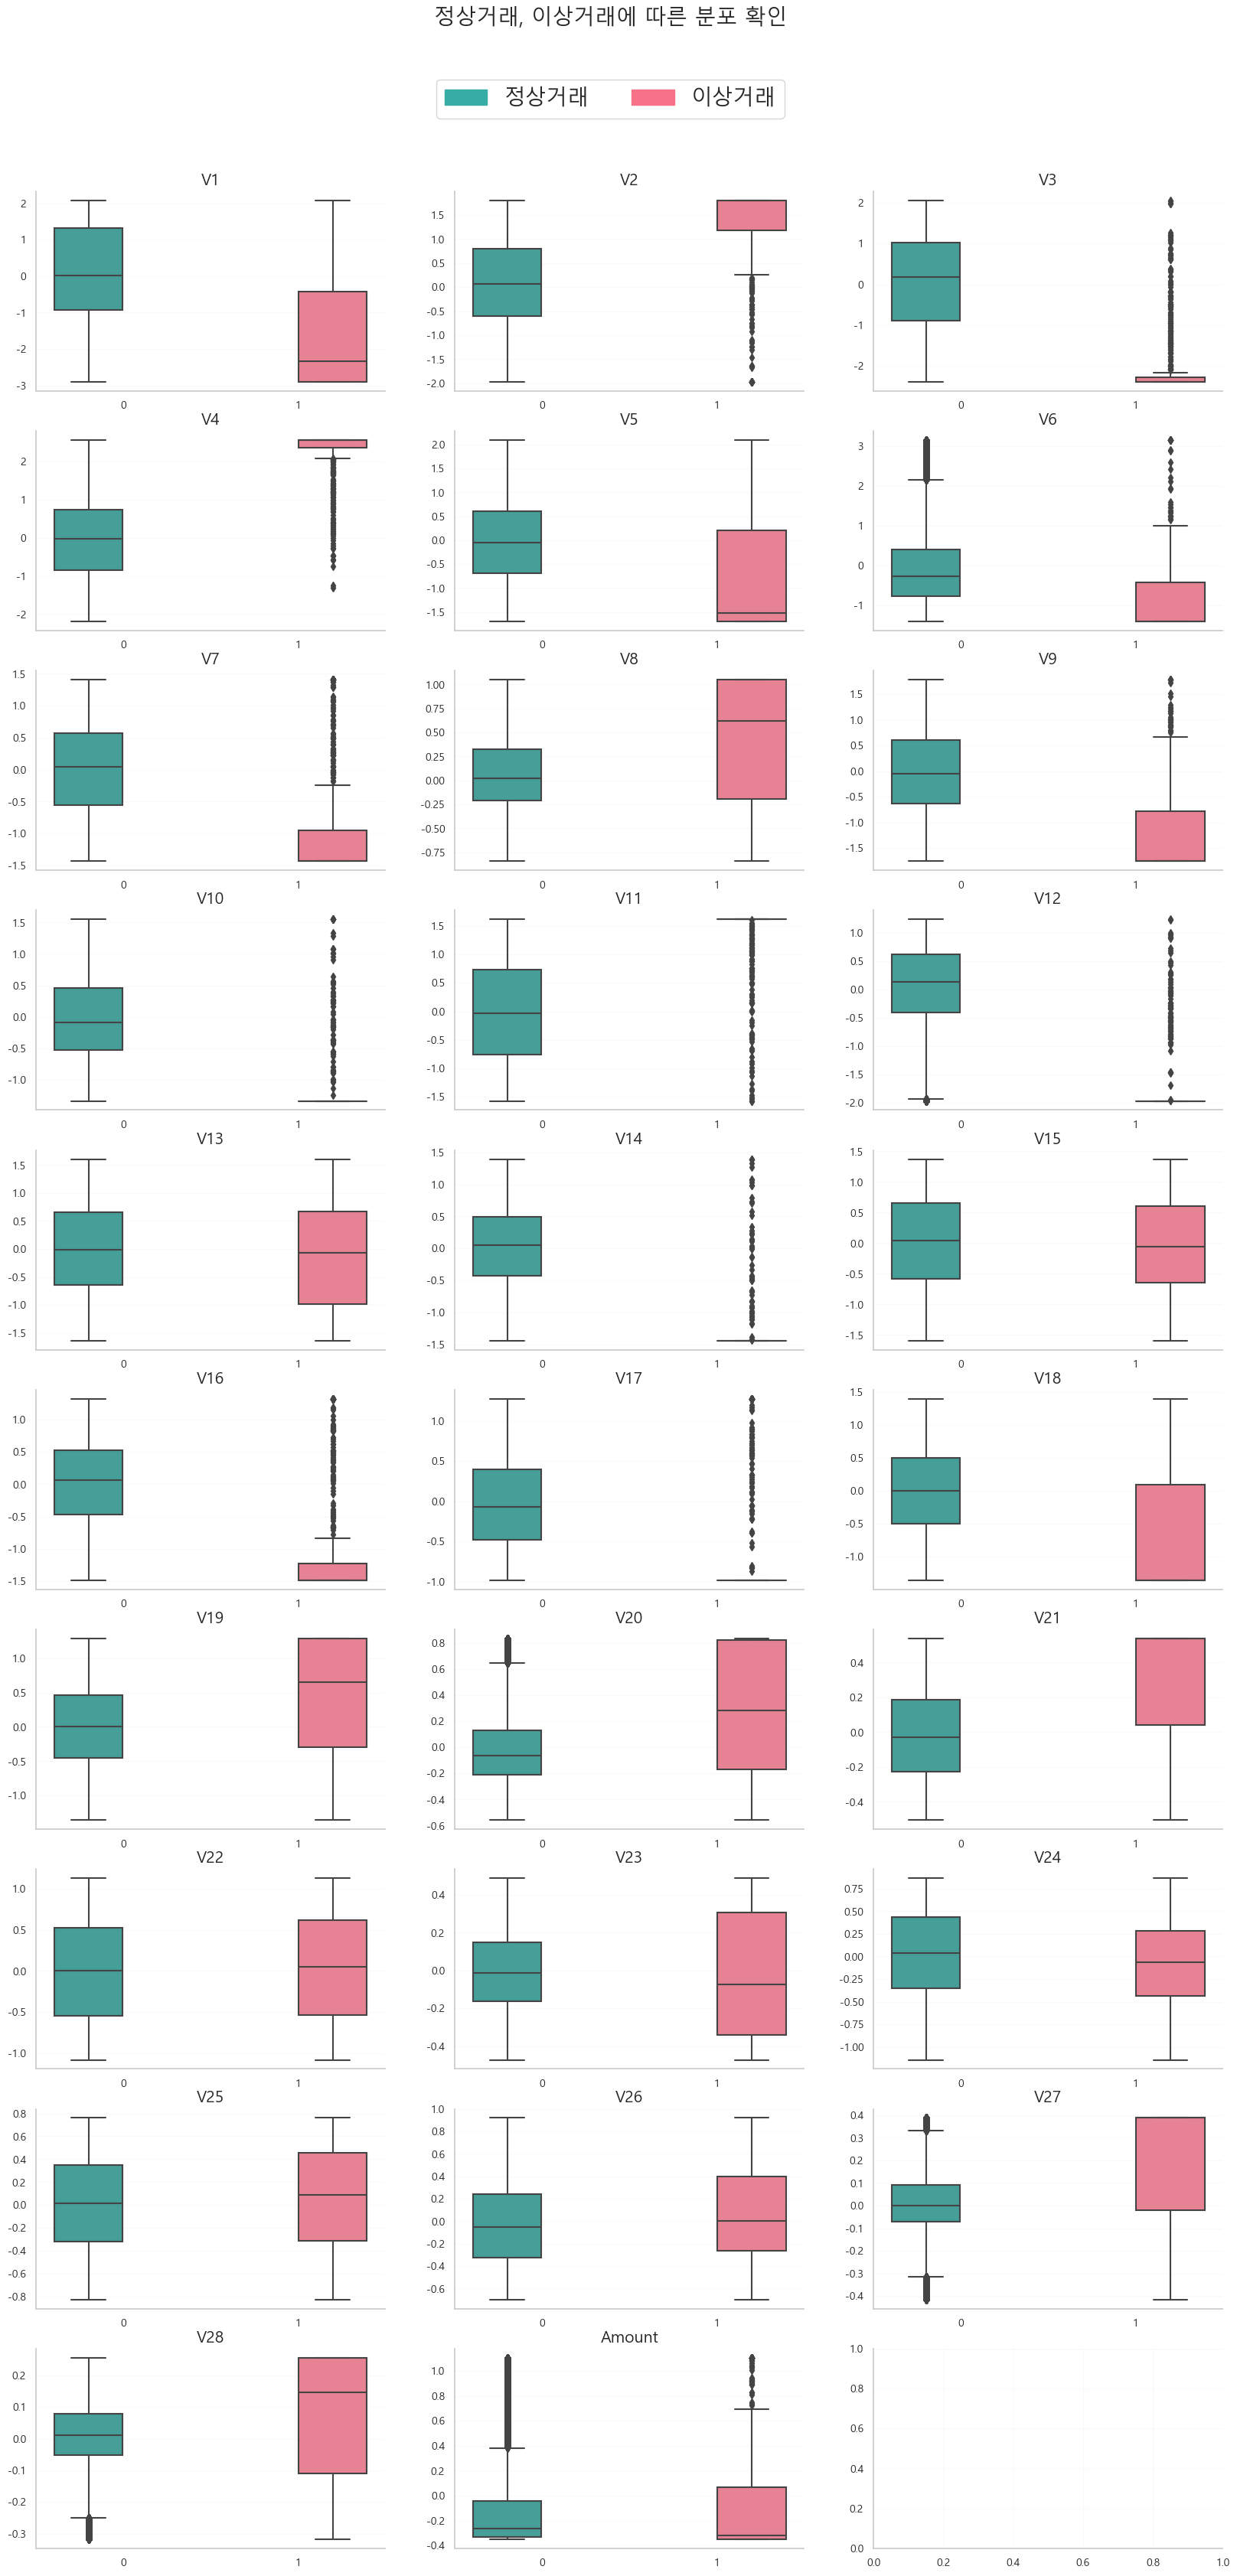

In [28]:
fig, ax = plt.subplots(10,3,figsize=(20, 40))

palette = ['#36ada4', '#f77189'] 

ax = ax.flatten()

total_col = data_w.columns
total_col = total_col.drop(['Class'])

for idx, col in enumerate(
    total_col):
    sns.boxplot(data=data_w, y= col, x="Class", hue='Class', ax=ax[idx])
    ax[idx].legend().remove()
    ax[idx].set(title = col)
    ax[idx].set(xlabel=None)
    ax[idx].set(ylabel=None)
    
labels = ['정상거래', '이상거래']

pop_a = mpatches.Patch(color = palette[0], label=labels[0])
pop_b = mpatches.Patch(color = palette[1], label=labels[1])

fig.legend(handles=[pop_a,pop_b], loc='upper center', bbox_to_anchor=(0.5, .92), fontsize=20, ncol=2)
fig.suptitle('정상거래, 이상거래에 따른 분포 확인', fontsize=20, y=.94)
plt.show()

# [5] Over Sampling

- Smote를 활용한 오버샘플링 진행

- 오버샘플링 전 Target값 분포 : Counter({0: 227451, 1: 394})
- 오버샘플링 후 Target값 분포 : Counter({0: 227451, 1: 227451})

In [29]:
y = data_w['Class']
X = data_w.drop(['Class'], axis = 1)

In [30]:
# train만 Smote
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 22)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227845, 29), (56962, 29), (227845,), (56962,))

In [31]:
sm = SMOTE(random_state=77)

X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [32]:
X_train_over.shape, y_train_over.shape

((454902, 29), (454902,))

In [33]:
print('오버샘플링 전 Target값 분포 :',Counter(y_train))
print('오버샘플링 후 Target값 분포 :',Counter(y_train_over))

오버샘플링 전 Target값 분포 : Counter({0: 227451, 1: 394})
오버샘플링 후 Target값 분포 : Counter({0: 227451, 1: 227451})


# [6] Machine Learning 학습

## [5-1] Random Forest
* Precision / recall / f1-score / accuracy 
- Train : 1 / 1 / 1 / 1
- Test : 0.94 / 0.92 / 0.93 / 1

In [34]:
%%time
rf_clf = RandomForestClassifier(random_state = 77)

rf_clf.fit(X_train_over, y_train_over)

CPU times: total: 4min 32s
Wall time: 4min 35s


RandomForestClassifier(random_state=77)

In [35]:
# Train 성능
pred_y_rf = rf_clf.predict(X_train_over)
pred_y_prob_rf = rf_clf.predict_proba(X_train_over)

print(classification_report(y_train_over, pred_y_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902



In [36]:
# test 성능
pred_y_test_rf = rf_clf.predict(X_test)
pred_y_prob_test_rf = rf_clf.predict_proba(X_test)

print(classification_report(y_test, pred_y_test_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.83      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962



## [5-2] LGBM 
* Precision / recall / f1-score / accuracy 
- Train : 1 / 1 / 1 / 1
- Test : 0.77 / 0.94 / 0.83 / 1

In [71]:
lgbm_clf = LGBMClassifier(random_state = 77, verbose = -1)

lgbm_clf.fit(X_train_over, y_train_over)

LGBMClassifier(random_state=77, verbose=-1)

In [72]:
# Train 성능
pred_y_lgb = lgbm_clf.predict(X_train_over)
pred_y_prob_lgb = lgbm_clf.predict_proba(X_train_over)

print(classification_report(y_train_over, pred_y_lgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902



In [73]:
# test 성능
pred_y_test_lgb = lgbm_clf.predict(X_test)
pred_y_prob_test_lgb = lgbm_clf.predict_proba(X_test)

print(classification_report(y_test, pred_y_test_lgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.58      0.86      0.69        98

    accuracy                           1.00     56962
   macro avg       0.79      0.93      0.85     56962
weighted avg       1.00      1.00      1.00     56962



### [+] LGBM 하이퍼파라미터 튜닝 (기본 모델의 낮은 f1 score)

* Precision / recall / f1-score / accuracy 
- Train : 1 / 1 / 1 / 1
- Test : 0.77 / 0.94 / 0.83 / 1

In [51]:
%%time

lgb_clf = lgb.LGBMClassifier(verbose = -1)


param_grid = {
    'n_estimators': [50, 100],  # lower number of trees => 과적합 방지
    'max_depth': [5, 8],  # limit tree depth 
    'learning_rate': [0.01, 0.05, 0.1],  # lower learning rate
    'colsample_bytree': [0.6, 0.7],  # lower feature sampling ratio
    'min_child_samples': [20, 30],   # add minimum child samples parameter
    'subsample': [0.7, 0.8]          # add data sampling ratio parameter
}

grid_search = GridSearchCV(lgb_clf, param_grid, scoring='f1', cv=3)

grid_search.fit(X_train_over, y_train_over)

# 최적의 하이퍼 파라미터 및 성능 출력
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best Score: ", -grid_search.best_score_)

# 최적 모델 획득
best_model_lgb = grid_search.best_estimator_

Best Hyperparameters:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_samples': 20, 'n_estimators': 100, 'subsample': 0.7}
Best Score:  -0.998884050326465
CPU times: total: 38min 7s
Wall time: 10min 18s


In [52]:
pred_y_t_lgb = best_model_lgb.predict(X_train_over)
pred_y_prob_lgb = best_model_lgb.predict_proba(X_train_over)

print(classification_report(y_train_over, pred_y_t_lgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902



In [53]:
pred_y_t_lgb = best_model_lgb.predict(X_test)
pred_y_t_prob_lgb = best_model_lgb.predict_proba(X_test)

print(classification_report(y_test, pred_y_t_lgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.42      0.87      0.57        98

    accuracy                           1.00     56962
   macro avg       0.71      0.93      0.78     56962
weighted avg       1.00      1.00      1.00     56962



## [5-3] XGB

* Precision / recall / f1-score / accuracy 
- Train : 1 / 1 / 1 / 1
- Test : 0.77 / 0.94 / 0.83 / 1

In [45]:
%%time

XGB_clf = XGBClassifier(random_state = 77)

XGB_clf.fit(X_train_over, y_train_over)

CPU times: total: 6min 59s
Wall time: 1min 45s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=77, ...)

In [46]:
# Train 성능
pred_y_xgb = XGB_clf.predict(X_train_over)
pred_y_prob_xgb = XGB_clf.predict_proba(X_train_over)

print(classification_report(y_train_over, pred_y_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902



In [47]:
# test 성능
pred_y_test_xgb = XGB_clf.predict(X_test)
pred_y_prob_test_xgb = XGB_clf.predict_proba(X_test)

print(classification_report(y_test, pred_y_test_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.84      0.82        98

    accuracy                           1.00     56962
   macro avg       0.90      0.92      0.91     56962
weighted avg       1.00      1.00      1.00     56962



## [5-4] Catboost

In [48]:
%%time

cb_clf = CatBoostClassifier(random_state = 77)

cb_clf.fit(X_train_over, y_train_over)

Learning rate set to 0.140561
0:	learn: 0.4320084	total: 216ms	remaining: 3m 36s
1:	learn: 0.3162099	total: 290ms	remaining: 2m 24s
2:	learn: 0.2493826	total: 372ms	remaining: 2m 3s
3:	learn: 0.2026913	total: 450ms	remaining: 1m 52s
4:	learn: 0.1723907	total: 526ms	remaining: 1m 44s
5:	learn: 0.1537877	total: 589ms	remaining: 1m 37s
6:	learn: 0.1402150	total: 653ms	remaining: 1m 32s
7:	learn: 0.1287268	total: 725ms	remaining: 1m 29s
8:	learn: 0.1191085	total: 791ms	remaining: 1m 27s
9:	learn: 0.1115479	total: 860ms	remaining: 1m 25s
10:	learn: 0.1029578	total: 936ms	remaining: 1m 24s
11:	learn: 0.0964817	total: 1.01s	remaining: 1m 22s
12:	learn: 0.0920002	total: 1.08s	remaining: 1m 21s
13:	learn: 0.0869485	total: 1.16s	remaining: 1m 22s
14:	learn: 0.0836120	total: 1.23s	remaining: 1m 21s
15:	learn: 0.0797592	total: 1.3s	remaining: 1m 20s
16:	learn: 0.0767135	total: 1.4s	remaining: 1m 20s
17:	learn: 0.0734016	total: 1.48s	remaining: 1m 20s
18:	learn: 0.0707194	total: 1.55s	remaining: 1m

In [49]:
# Train 성능
pred_y_cb = cb_clf.predict(X_train_over).reshape(-1,)
pred_y_prob_cb = cb_clf.predict_proba(X_train_over)

print(classification_report(y_train_over, pred_y_cb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902



In [50]:
# test 성능
pred_y_test_cb = cb_clf.predict(X_test).reshape(-1,)
pred_y_prob_test_cb = cb_clf.predict_proba(X_test)

print(classification_report(y_test, pred_y_test_cb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.72      0.86      0.79        98

    accuracy                           1.00     56962
   macro avg       0.86      0.93      0.89     56962
weighted avg       1.00      1.00      1.00     56962



## [5-5] Logistic Regression : 사용하지 않는다. (test에서 성능이 너무 떨어짐)

In [42]:
%%time

lr_clf = LogisticRegression(random_state = 77)

lr_clf.fit(X_train_over, y_train_over)

CPU times: total: 9.84 s
Wall time: 2.47 s


LogisticRegression(random_state=77)

In [43]:
# Train 성능
pred_y_lr = lr_clf.predict(X_train_over)
pred_y_prob_lr = lr_clf.predict_proba(X_train_over)

print(classification_report(y_train_over, pred_y_lr))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95    227451
           1       0.96      0.92      0.94    227451

    accuracy                           0.95    454902
   macro avg       0.95      0.95      0.95    454902
weighted avg       0.95      0.95      0.95    454902



In [44]:
# test 성능
pred_y_test_lr = lr_clf.predict(X_test)
pred_y_prob_test_lr = lr_clf.predict_proba(X_test)

print(classification_report(y_test, pred_y_test_lr))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.95      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.96      0.54     56962
weighted avg       1.00      0.97      0.98     56962



## [5-6] Decision Tree

In [61]:
dt_clf = DecisionTreeClassifier(random_state = 22)

dt_clf.fit(X_train_over, y_train_over)

DecisionTreeClassifier(random_state=22)

In [62]:
# Train 성능
pred_y_dt = dt_clf.predict(X_train_over)
pred_y_prob_dt = dt_clf.predict_proba(X_train_over)

print(classification_report(y_train_over, pred_y_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       1.00      1.00      1.00    227451

    accuracy                           1.00    454902
   macro avg       1.00      1.00      1.00    454902
weighted avg       1.00      1.00      1.00    454902



In [63]:
# test 성능
pred_y_test_dt = dt_clf.predict(X_test)
pred_y_prob_test_dt = dt_clf.predict_proba(X_test)

print(classification_report(y_test, pred_y_test_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.41      0.81      0.54        98

    accuracy                           1.00     56962
   macro avg       0.70      0.90      0.77     56962
weighted avg       1.00      1.00      1.00     56962



# [6] 학습 결과 스태킹, 성능 확인

In [76]:
predictions_df = pd.DataFrame({
    'rf': list(pred_y_test_rf), 
    'xgb': list(pred_y_test_xgb),  
    'lgb': list(pred_y_test_lgb),   
    'DT' : list(pred_y_test_dt),
    'cbc' : list(pred_y_test_cb)
})

stacking_y = list(y_test)

In [77]:
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(predictions_df, stacking_y, test_size=0.2, random_state=7, stratify = stacking_y)

In [78]:
# RF
rf_clf_st = RandomForestClassifier()
rf_clf_st.fit(X_train_st, y_train_st)

y_pred_rf_st = rf_clf_st.predict(X_test_st)
pred_y_prob_rf_st = rf_clf_st.predict_proba(X_test_st)

In [79]:
# 최종 성능
print(classification_report(y_test_st, y_pred_rf_st))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11373
           1       0.76      0.80      0.78        20

    accuracy                           1.00     11393
   macro avg       0.88      0.90      0.89     11393
weighted avg       1.00      1.00      1.00     11393

